# __Movie Sentiment Analysis using LSTM and GRU__

In [83]:
import pandas as pd
import numpy as np
import re
import contractions
import nltk
import contractions
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import text_preprocessing as tp
import utils
import spacy
import seaborn as sb
import tensorflow as tf

from tensorflow import keras as ks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from nltk.corpus import words
from flashtext import KeywordProcessor
from wordcloud import WordCloud
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, classification_report
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize


warnings.filterwarnings("ignore")

## Importing Dataset for Movie Metadata

Use the IMDB dataset containing information about movies. Two different data sources will be utilized in the process of traning the model.

__a. Data Source:__ https://www.kaggle.com/datasets/rounakbanik/the-movies-dataset/

In [84]:
# Open file containing movie metadata
movies_metadata_df = pd.read_csv("./dataset/movies_metadata.csv")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,10/30/1995,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,12/15/1995,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,12/22/1995,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,12/22/1995,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,2/10/1995,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [85]:
# Open file containing the movie credits, i.e. casts and crews
movies_credits_df = pd.read_csv("./dataset/credits.csv")
movies_credits_df.head(5)

,cast,crew,id
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",862
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",8844
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de...",15602
3,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de...",31357
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de...",11862


In [86]:
# Combine the dataframes of movie metadata and credits
movies_metadata_df = pd.merge(movies_metadata_df, movies_credits_df, on=["id"], how="left")
movies_metadata_df.head(5)

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,cast,crew
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


In [87]:
# List all the columns in movie metadata's dataframe
movies_metadata_df.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count', 'cast', 'crew'],
      dtype='object')

In [88]:
# Drop columns that are not relevant
del_columns = ['belongs_to_collection', 'homepage', 'id', 'original_language', 'original_title', 'popularity', 'poster_path', 'adult',
               'overview', 'tagline', 'production_countries', 'spoken_languages', 'status', 'video', 'vote_average', 'vote_count']
movies_metadata_df = movies_metadata_df.drop(del_columns, axis=1)

# Remove 'tt' appended on the IMDB ID
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].apply(lambda x : x[2:] if isinstance(x, str) and "tt" in x else x)

movies_metadata_df.head(5)

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,cast,crew
0,30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",0114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,373554033.0,81.0,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",0113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,262797249.0,104.0,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",0113228,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...",12/22/1995,0.0,101.0,Grumpier Old Men,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{'credit_id': '52fe466a9251416c75077a89', 'de..."
3,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",0114885,[{'name': 'Twentieth Century Fox Film Corporat...,12/22/1995,81452156.0,127.0,Waiting to Exhale,"[{'cast_id': 1, 'character': ""Savannah 'Vannah...","[{'credit_id': '52fe44779251416c91011acb', 'de..."
4,0,"[{'id': 35, 'name': 'Comedy'}]",0113041,"[{'name': 'Sandollar Productions', 'id': 5842}...",2/10/1995,76578911.0,106.0,Father of the Bride Part II,"[{'cast_id': 1, 'character': 'George Banks', '...","[{'credit_id': '52fe44959251416c75039ed7', 'de..."


__b. Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [89]:
# Open another file containing the movie metadata
movies_df = pd.read_csv("./dataset/movies.csv")
movies_df.head(5)

,imdbId,Imdb Link,Title,IMDB Score,Genre,local_image_path
0,114709,http://www.imdb.com/title/tt114709,Toy Story (1995),8.3,Animation;Adventure;Comedy,images/114709_.jpg
1,113497,http://www.imdb.com/title/tt113497,Jumanji (1995),6.9,Action;Adventure;Family,images/113497_.jpg
2,113277,http://www.imdb.com/title/tt113277,Heat (1995),8.2,Action;Crime;Drama,images/113277_.jpg
3,114319,http://www.imdb.com/title/tt114319,Sabrina (1995),6.3,Comedy;Drama,images/114319_.jpg
4,114576,http://www.imdb.com/title/tt114576,Sudden Death (1995),5.7,Action;Crime;Thriller,images/114576_.jpg


In [90]:
# Rename the column names of movies info by removing the spaces and converting to lower case
movies_df = movies_df.rename(columns={"imdbId" : "imdb_id", "Imdb Link" : "imbd_link", "Title" : "movie", "IMDB Score" : "imdb_score", "Genre" : "genre"})
print(movies_df.columns)

Index(['imdb_id', 'imbd_link', 'movie', 'imdb_score', 'genre',
       'local_image_path'],
      dtype='object')


In [91]:
# Drop columns that are not relevant
del_columns = ['imbd_link', 'imdb_score', 'local_image_path']

movies_df = movies_df.drop(columns=del_columns, axis=1)
movies_df.head(5)

,imdb_id,movie,genre
0,114709,Toy Story (1995),Animation;Adventure;Comedy
1,113497,Jumanji (1995),Action;Adventure;Family
2,113277,Heat (1995),Action;Crime;Drama
3,114319,Sabrina (1995),Comedy;Drama
4,114576,Sudden Death (1995),Action;Crime;Thriller


In [92]:
# Merge two different datasets for movies metadata

movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].fillna(0) # fixed errors on NaN values when converting to int data type
movies_metadata_df['imdb_id'] = movies_metadata_df['imdb_id'].astype(int)

movies_metadata_df = pd.merge(movies_metadata_df, movies_df, on=["imdb_id"], how="right")
movies_metadata_df.head(5)

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,cast,crew,movie,genre
0,30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",114709,"[{'name': 'Pixar Animation Studios', 'id': 3}]",10/30/1995,373554033.0,81.0,Toy Story,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de...",Toy Story (1995),Animation;Adventure;Comedy
1,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",113497,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...",12/15/1995,262797249.0,104.0,Jumanji,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de...",Jumanji (1995),Action;Adventure;Family
2,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",113277,"[{'name': 'Regency Enterprises', 'id': 508}, {...",12/15/1995,187436818.0,170.0,Heat,"[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de...",Heat (1995),Action;Crime;Drama
3,58000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",114319,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...",12/15/1995,0.0,127.0,Sabrina,"[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de...",Sabrina (1995),Comedy;Drama
4,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",114576,"[{'name': 'Universal Pictures', 'id': 33}, {'n...",12/22/1995,64350171.0,106.0,Sudden Death,"[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de...",Sudden Death (1995),Action;Crime;Thriller


## Importing Dataset for Movie Reviews

Use the IMDB dataset for movie reviews.

__Data Source:__ https://www.kaggle.com/datasets/raynardj/imdb-vision-and-nlp/data

In [93]:
# Open the file containing the movie reviews
reviews_df = pd.read_csv("./dataset/reviews.csv")
reviews_df.head(5)

,review_id,reviewer,movie,rating,review_summary,review_date,spoiler_tag,review_detail,helpful,roberta_sentiment
0,rw0213367,SUPERNOVA HEIGHTS,A Nightmare on Elm Street (1984),8.0,A Classic of the horror films History,27 August 2003,0,This is the beginning of a great horror film s...,"['0', '0']",Positive
1,rw0213369,kibler@adelphia.net,A Nightmare on Elm Street (1984),NaN,Better than your average horror movie,1 September 2003,0,"Nightmare on Elm Street, A (1984) John Saxon, ...","['0', '0']",Negative
2,rw0213371,matthew87,A Nightmare on Elm Street (1984),NaN,good slasher flick,1 September 2003,0,"the best freddy film period,1 because the horr...","['0', '0']",Strongly Positive
3,rw0213375,rossrobinson,A Nightmare on Elm Street (1984),10.0,A nightmare on elm st part 1,27 September 2003,0,I remember seeing a nightmare on elm street pa...,"['0', '2']",Negative
4,rw0213376,Andres24,A Nightmare on Elm Street (1984),9.0,Highway to hell,3 October 2003,0,"It's a nightmare. If Nancy falls asleep, they...","['1', '1']",Positive


In [94]:
# Merge the movie metadata (from the same kaggle source) and reviews
movie_reviews_df = pd.merge(movies_df, reviews_df, on=["movie"], how="inner")
movie_reviews_df.head(5)

,imdb_id,movie,genre,review_id,reviewer,rating,review_summary,review_date,spoiler_tag,review_detail,helpful,roberta_sentiment
0,114709,Toy Story (1995),Animation;Adventure;Comedy,rw1223346,KUAlum26,10.0,Can it be ten years already?,23 November 2005,0,PIXAR animation was but an experimental animat...,"['1', '1']",Positive
1,114709,Toy Story (1995),Animation;Adventure;Comedy,rw3110243,MUFCOK,10.0,A childhood favourite,24 October 2014,0,Toy Story is one of those movies which holds a...,"['1', '2']",Strongly Positive
2,114709,Toy Story (1995),Animation;Adventure;Comedy,rw3109622,Rainey-Dawn,6.0,Not As Good As I Was Hoping,23 October 2014,0,"This is another one of my ""I should like this ...","['2', '8']",Neutral
3,114709,Toy Story (1995),Animation;Adventure;Comedy,rw3124846,byson5186,9.0,Why The First Toy Story Is My Favorite,15 November 2014,0,So far they have come out with 3 Toy Story mov...,"['0', '1']",Positive
4,114709,Toy Story (1995),Animation;Adventure;Comedy,rw3635799,snperera,9.0,A classic friendship story!,8 February 2017,0,"Wow, well what can I say! This is a favorite o...","['0', '1']",Strongly Positive


In [95]:
# Drop columns that are not relevant, including the movie and genre. IMDB ID can be used to associate 
# review records with movie metadata
del_columns = ['movie', 'genre', 'review_id', 'reviewer', 'spoiler_tag', 'helpful']

movie_reviews_df = movie_reviews_df.drop(columns=del_columns, axis=1)
movie_reviews_df.head(5)

,imdb_id,rating,review_summary,review_date,review_detail,roberta_sentiment
0,114709,10.0,Can it be ten years already?,23 November 2005,PIXAR animation was but an experimental animat...,Positive
1,114709,10.0,A childhood favourite,24 October 2014,Toy Story is one of those movies which holds a...,Strongly Positive
2,114709,6.0,Not As Good As I Was Hoping,23 October 2014,"This is another one of my ""I should like this ...",Neutral
3,114709,9.0,Why The First Toy Story Is My Favorite,15 November 2014,So far they have come out with 3 Toy Story mov...,Positive
4,114709,9.0,A classic friendship story!,8 February 2017,"Wow, well what can I say! This is a favorite o...",Strongly Positive


## Exploratory Data Analysis

Check and resolve duplicate records

In [96]:
# Drop duplicate records in movies metadata
print(f"Record count before removing duplicates => {movies_metadata_df.shape[0]}")
movies_metadata_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movies_metadata_df.shape[0]}")

Record count before removing duplicates => 4174
Record count after removing duplicates  => 4071


In [97]:
# Drop duplicate records in movies reviews
print(f"Record count before removing duplicates => {movie_reviews_df.shape[0]}")
movie_reviews_df.drop_duplicates(inplace=True)
print(f"Record count after removing duplicates  => {movie_reviews_df.shape[0]}")

Record count before removing duplicates => 557580
Record count after removing duplicates  => 542632


Check and resolve missing values for `movie metadata`

In [98]:
# Check for missing values in movies metadata
movies_metadata_df.isna().sum()

budget                  3
genres                  3
imdb_id                 0
production_companies    3
release_date            3
revenue                 3
runtime                 3
title                   3
cast                    3
crew                    3
movie                   0
genre                   0
dtype: int64

In [99]:
# List of movies with missing information
movies_metadata_df[movies_metadata_df['title'].isna()]

,budget,genres,imdb_id,production_companies,release_date,revenue,runtime,title,cast,crew,movie,genre
2780,NaN,NaN,462322,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Grindhouse (2007),Action;Horror;Thriller
3521,NaN,NaN,448694,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Puss in Boots (2011),Animation;Action;Adventure
3793,NaN,NaN,1937390,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nymphomaniac: Vol. I (2013),Drama


In [100]:
# Drop all movies with missing information
movies_metadata_df.dropna(inplace=True, axis=0)
movies_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4068 entries, 0 to 4173
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                4068 non-null   float64
 1   genres                4068 non-null   object 
 2   imdb_id               4068 non-null   int64  
 3   production_companies  4068 non-null   object 
 4   release_date          4068 non-null   object 
 5   revenue               4068 non-null   float64
 6   runtime               4068 non-null   float64
 7   title                 4068 non-null   object 
 8   cast                  4068 non-null   object 
 9   crew                  4068 non-null   object 
 10  movie                 4068 non-null   object 
 11  genre                 4068 non-null   object 
dtypes: float64(3), int64(1), object(8)
memory usage: 413.2+ KB


Check and resolve missing values for `movie reviews`

In [101]:
# Check for missing values in movies reviews
movie_reviews_df.isna().sum()

imdb_id                  0
rating               76869
review_summary           1
review_date              0
review_detail            0
roberta_sentiment        0
dtype: int64

In [102]:
# Replace all missing values in review summary and detail with a blank
movie_reviews_df[['review_summary', 'review_detail']] = movie_reviews_df[['review_summary', 'review_detail']].fillna('')
movie_reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542632 entries, 0 to 557579
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   imdb_id            542632 non-null  int64  
 1   rating             465763 non-null  float64
 2   review_summary     542632 non-null  object 
 3   review_date        542632 non-null  object 
 4   review_detail      542632 non-null  object 
 5   roberta_sentiment  542632 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 29.0+ MB


In [103]:
# Define a mapping for sentiment to rating
sentiment_to_rating = {
    'Strongly Positive' : 1,
    'Positive': 8,
    'Neutral': 5,
    'Negative': 2,
    'Strongly Negative': 10
}

# Fill null values in the 'rating' column based on the 'sentiment' column
movie_reviews_df['rating'].fillna(movie_reviews_df['roberta_sentiment'].map(sentiment_to_rating), inplace=True)

# Convert the ratings to integer type
movie_reviews_df['rating'] = movie_reviews_df['rating'].astype(int)
movie_reviews_df['rating'].info()

<class 'pandas.core.series.Series'>
Int64Index: 542632 entries, 0 to 557579
Series name: rating
Non-Null Count   Dtype
--------------   -----
542632 non-null  int32
dtypes: int32(1)
memory usage: 6.2 MB


#### __Data Wrangling and Visualizations__:

Conduct data wrangling on `movie metadata` to transform and structure data into a desired format

In [104]:
# Separate movie release year from the title
pattern_year = r'\((\d{4})\)$'
movies_metadata_df['release_year'] = movies_metadata_df['movie'].str.extract(pattern_year).astype(int)
movies_metadata_df['movie'] = movies_metadata_df['movie'].str.replace(pattern_year, '', regex=True).str.strip()
movies_metadata_df[['movie', 'release_year']].head(5)

# Drop columns containing duplicate movie information
dup_columns = ['genres', 'release_date', 'title']
movies_metadata_df = movies_metadata_df.drop(columns=dup_columns, axis=1)

# Rearrange the order of columns
desired_order = ['imdb_id', 'movie', 'release_year', 'genre', 'runtime', 'budget', 'revenue', 'production_companies', 'cast', 'crew']
movies_metadata_df = movies_metadata_df[desired_order]

movies_metadata_df.head(5)

,imdb_id,movie,release_year,genre,runtime,budget,revenue,production_companies,cast,crew
0,114709,Toy Story,1995,Animation;Adventure;Comedy,81.0,30000000.0,373554033.0,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,113497,Jumanji,1995,Action;Adventure;Family,104.0,65000000.0,262797249.0,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,113277,Heat,1995,Action;Crime;Drama,170.0,60000000.0,187436818.0,"[{'name': 'Regency Enterprises', 'id': 508}, {...","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,114319,Sabrina,1995,Comedy;Drama,127.0,58000000.0,0.0,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de..."
4,114576,Sudden Death,1995,Action;Crime;Thriller,106.0,35000000.0,64350171.0,"[{'name': 'Universal Pictures', 'id': 33}, {'n...","[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de..."


In [105]:
# Convert genre into list data type
movies_metadata_df['genre'] = movies_metadata_df['genre'].apply(lambda x : x.split(";"))

# Convert to a list of production companies
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies'].apply(lambda x : utils.convert_str_to_dict(x, ['name']))
movies_metadata_df['production_companies'] = movies_metadata_df['production_companies'].apply(lambda list_of_dicts : [value for d in list_of_dicts for value in d.values()])

# TODO: Need to fix the issue on cast and crew with names containing single quotation
# movies_metadata_df['cast'] = movies_metadata_df['cast'].apply(lambda x : utils.convert_str_to_dict(x, ['character', 'name']))

movies_metadata_df[['genre', 'production_companies', 'cast', 'crew']].head(5)

,genre,production_companies,cast,crew
0,"[Animation, Adventure, Comedy]",[Pixar Animation Studios],"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{'credit_id': '52fe4284c3a36847f8024f49', 'de..."
1,"[Action, Adventure, Family]","[TriStar Pictures, Teitler Film, Interscope Co...","[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{'credit_id': '52fe44bfc3a36847f80a7cd1', 'de..."
2,"[Action, Crime, Drama]","[Regency Enterprises, Forward Pass, Warner Bros.]","[{'cast_id': 25, 'character': 'Lt. Vincent Han...","[{'credit_id': '52fe4292c3a36847f802916d', 'de..."
3,"[Comedy, Drama]","[Paramount Pictures, Scott Rudin Productions, ...","[{'cast_id': 1, 'character': 'Linus Larrabee',...","[{'credit_id': '52fe44959251416c75039da9', 'de..."
4,"[Action, Crime, Thriller]","[Universal Pictures, Imperial Entertainment, S...","[{'cast_id': 1, 'character': 'Darren Francis T...","[{'credit_id': '52fe44dbc3a36847f80ae0f1', 'de..."


Conduct data wrangling on `movie review` to transform and structure data into a desired format

In [106]:
# Get only the year the review was created
movie_reviews_df['review_year'] = pd.to_datetime(movie_reviews_df['review_date']).dt.year
movie_reviews_df = movie_reviews_df.drop(columns=['review_date'], axis=1)

movie_reviews_df.head(5)

,imdb_id,rating,review_summary,review_detail,roberta_sentiment,review_year
0,114709,10,Can it be ten years already?,PIXAR animation was but an experimental animat...,Positive,2005
1,114709,10,A childhood favourite,Toy Story is one of those movies which holds a...,Strongly Positive,2014
2,114709,6,Not As Good As I Was Hoping,"This is another one of my ""I should like this ...",Neutral,2014
3,114709,9,Why The First Toy Story Is My Favorite,So far they have come out with 3 Toy Story mov...,Positive,2014
4,114709,9,A classic friendship story!,"Wow, well what can I say! This is a favorite o...",Strongly Positive,2017


In [107]:
# Combine 'positive' and 'strongly positive' reviews, and 'negative' and 'strongly negative' reciews
movie_reviews_df['roberta_sentiment'] = movie_reviews_df['roberta_sentiment'].replace('Strongly Positive', 'Positive')
movie_reviews_df['roberta_sentiment'] = movie_reviews_df['roberta_sentiment'].replace('Strongly Negative', 'Negative')
movie_reviews_df['roberta_sentiment'].value_counts().unique

<bound method Series.unique of Positive    257636
Neutral     161133
Negative    123863
Name: roberta_sentiment, dtype: int64>

Perform additional analysis of the data and create visual representations to gain a better understanding of the movie metadata and reviews. This information provides insights on trends and patterns in the movie data, which might be important especially on the reports that will be provided to the client.

In [108]:
# Show statistical summary of movie metadata and reviews
pd.merge(movies_metadata_df, movie_reviews_df, on=["imdb_id"], how="inner").describe()

,imdb_id,release_year,runtime,budget,revenue,rating,review_year
count,5.425060e+05,542506.000000,542506.000000,5.425060e+05,5.425060e+05,542506.000000,542506.000000
mean,5.652383e+05,1995.808013,112.443689,4.209220e+07,1.550479e+08,6.633604,2010.015576
std,7.657246e+05,18.337994,22.431029,5.340403e+07,2.477374e+08,2.534820,6.248968
min,4.170000e+02,1902.000000,0.000000,0.000000e+00,0.000000e+00,1.000000,1998.000000
25%,9.607100e+04,1988.000000,97.000000,3.500000e+06,1.040000e+07,5.000000,2005.000000
50%,2.571060e+05,2002.000000,109.000000,2.100000e+07,6.161977e+07,7.000000,2010.000000
75%,7.654290e+05,2008.000000,124.000000,6.000000e+07,1.874368e+08,8.000000,2015.000000
max,5.247022e+06,2017.000000,254.000000,3.800000e+08,2.787965e+09,10.000000,2021.000000


Tally the number of reviews categorized by customer ratings ranging from 1 (lowest) to 10 (highest) to gauge the overall sentiment of the dataset based on these ratings. Get the frequency for each review sentiment as well, which was based from RoBERTa.

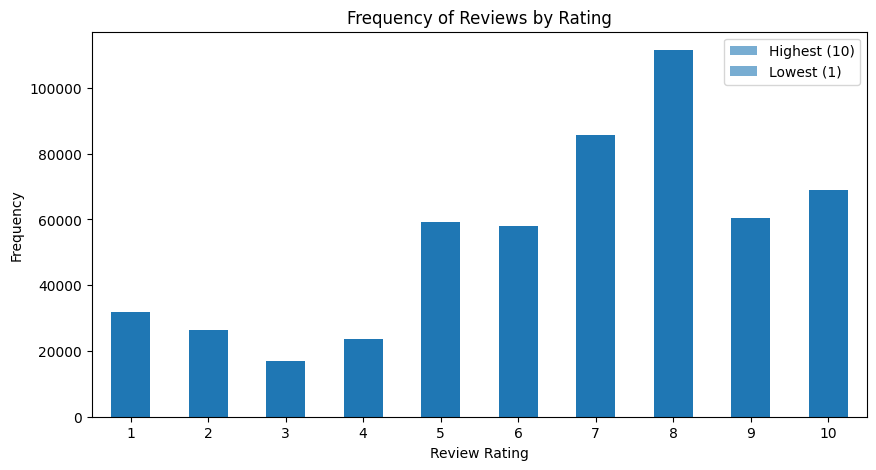

In [109]:
# Count the reviews based on customer ratings
ax = movie_reviews_df['rating'].value_counts().sort_index() \
    .plot(kind='bar', title='Frequency of Reviews by Rating', figsize=(10, 5))

ax.set_xlabel('Review Rating')
ax.set_ylabel('Frequency')

# Add a custom legend indicating 10 as highest and 1 as lowest
legend_labels = {10: 'Highest (10)', 1: 'Lowest (1)'}
legend_handles = [plt.Rectangle((0, 0), 1, 1, alpha=0.6, label=label)
                  for rating, label in legend_labels.items()]

ax.legend(handles=legend_handles, labels=legend_labels.values(), loc='upper right')
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()

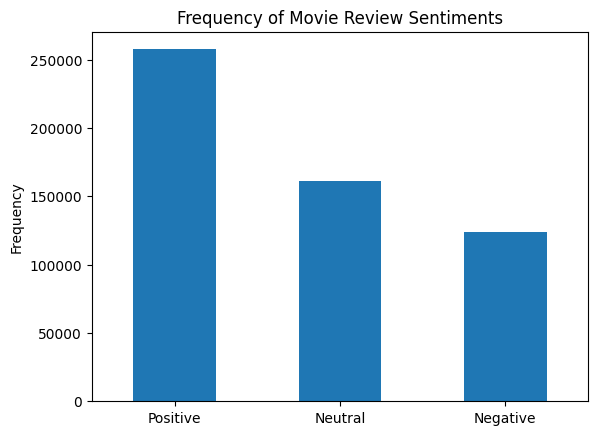

In [110]:
# Get the frequency of values in the 'roberta_sentiment' column
sentiment_counts = movie_reviews_df['roberta_sentiment'].value_counts()
sentiment_counts.plot(kind='bar')

plt.ylabel('Frequency')
plt.title('Frequency of Movie Review Sentiments')
plt.xticks(rotation=0)
plt.show()

#### __For Text Pre-processing__:

__The movie summary and reviews undergo the following steps during the initial data pre-processing stage__
- Remove non-grammatical text like emails and URLs
- Replace non-ascii characters (some Python libraries are only limited to ascii characters like KeywordProcessor)
- Replace emojis with English word/s
- Handle contractions
- Handle slang words

In [111]:
emoji_dict = tp.get_emojis()
slang_word_dict = tp.get_slang_words(webscraped=False)

def conduct_text_preprocessing(text):
    try:
        # Remove non-grammatical text
        text = tp.remove_email_address(text)
        text = tp.remove_hyperlink(text)

        # Replace non-ascii characters as there are Python libraries limiting this feature
        text = tp.replace_nonascii_characters(text)

        # Replace emojis with English word/s
        text = emoji_dict.replace_keywords(text)

        # Handle contractions
        text = contractions.fix(text)

        # Replace slang words
        text = slang_word_dict.replace_keywords(text)

        # Remove leading and trailing whitespaces
        text = text.strip()

        # Replace multiple whitespaces with a single space
        text = tp.replace_whitespace(text)

    except Exception as err:
        print(f"ERROR: {err}")
        print(f"Input Text: {text}")

    return text


movie_reviews_df[['cleaned_review_summary', 'cleaned_review_detail']] = movie_reviews_df[['review_summary', 'review_detail']].applymap(conduct_text_preprocessing)

# Display the comparison between the top 5 original review summaries and their cleaned versions
for i in range(5):
    print("Original Review Summary:")
    print(movie_reviews_df['review_summary'][i])
    print("\nCleaned Review Summary:")
    print(movie_reviews_df['cleaned_review_summary'][i])
    print("="*100)

# Display the comparison between the top 5 original review details and their cleaned versions
for i in range(5):
    print("Original Review Details:")
    print(movie_reviews_df['review_detail'][i])
    print("\nCleaned Review Details:")
    print(movie_reviews_df['cleaned_review_detail'][i])
    print("="*100)

Original Review Summary:
Can it be ten years already?

Cleaned Review Summary:
Can it be ten years already?
Original Review Summary:
A childhood favourite

Cleaned Review Summary:
A childhood favourite
Original Review Summary:
Not As Good As I Was Hoping

Cleaned Review Summary:
Not As Good As I Was Hoping
Original Review Summary:
Why The First Toy Story Is My Favorite

Cleaned Review Summary:
Why The First Toy Story Is My Favorite
Original Review Summary:
A classic friendship story!

Cleaned Review Summary:
A classic friendship story!
Original Review Details:
PIXAR animation was but an experimental animation company that had a track record of short film contributions to film festivals when Disney invested in and ultimately released their first project,Toy Story. I figured Disney probably had a good feeling about this one,but I'm not sure they anticipated the kind of groundbreaking swell of animation this would shepherd in.The concept is a fitfully simple and cute one: when kids are aw

In [112]:
# Drop the old reviews and detail, replacing them with the pre-processed one
movie_reviews_df['review_summary'] = movie_reviews_df['cleaned_review_summary']
movie_reviews_df['review_detail'] = movie_reviews_df['cleaned_review_detail']

movie_reviews_df = movie_reviews_df.drop(columns=['cleaned_review_summary', 'cleaned_review_detail'], axis=1)
movie_reviews_df.head(5)

,imdb_id,rating,review_summary,review_detail,roberta_sentiment,review_year
0,114709,10,Can it be ten years already?,PIXAR animation was but an experimental animat...,Positive,2005
1,114709,10,A childhood favourite,Toy Story is one of those movies which holds a...,Positive,2014
2,114709,6,Not As Good As I Was Hoping,"This is another one of my ""I should like this ...",Neutral,2014
3,114709,9,Why The First Toy Story Is My Favorite,So far they have come out with 3 Toy Story mov...,Positive,2014
4,114709,9,A classic friendship story!,"Wow, well what can I say! This is a favorite o...",Positive,2017


Generate word clouds the can help to visualize the most frequent words in the review_details and review_summary columns

In [113]:
# # Function to generate word cloud from BoW and display top 10 words with count and BoW percentage in a table
# def generate_wordcloud_with_table(bow_matrix, title):
#     feature_names = vectorizer.get_feature_names_out()
#     word_freq = dict(zip(feature_names, bow_matrix.sum(axis=0).tolist()[0]))
#     wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    
#     # Get total words in BoW
#     total_words_bow = sum(word_freq.values())
    
#     # Get top 10 words with counts and calculate their percentages based on BoW
#     top_10_words = Counter(word_freq).most_common(10)
#     table_data = [['Word', 'Frequency', 'Percentage (of BoW)']]
    
#     for word, freq in top_10_words:
#         bow_percentage = round((freq / total_words_bow) * 100, 2)
#         table_data.append([word, freq, f"{bow_percentage}%"])

#     # Display word cloud and table showing top 10 words, their frequency, and BoW percentages
#     plt.figure(figsize=(8, 8))
#     plt.subplot(2, 1, 1)
#     plt.imshow(wordcloud, interpolation='bilinear')
#     plt.axis('off')
#     plt.title(title)
    
#     plt.subplot(2, 1, 2)
#     table = plt.table(cellText=table_data, loc='center', cellLoc='center', colColours=['lightgray'] * 3)
#     table.auto_set_font_size(False)
#     table.set_fontsize(10)
#     table.scale(1, 1.5)

#     plt.axis('off')
#     plt.tight_layout()
#     plt.show()


# sentiment_list = ['Positive', 'Neutral', 'Negative']

# for sentiment in sentiment_list:
#     query_result = movie_reviews_df.query("roberta_sentiment == @sentiment")

#     vectorizer = CountVectorizer()
#     # Generate word cloud and display top 10 words with frequency and BoW percentage for review detail BoW
#     review_detail_bow = vectorizer.fit_transform(query_result['review_detail'])
#     generate_wordcloud_with_table(review_detail_bow, 'Review Detail ' + sentiment)

#     # Generate word cloud and display top 10 words with frequency and BoW percentage for review summary BoW
#     review_summary_bow = vectorizer.fit_transform(query_result['review_summary'])
#     generate_wordcloud_with_table(review_summary_bow, 'Review Summary ' + sentiment)

#### __For Feature Selection and Engineering__:

In [114]:
# Transform 'roberta_sentiment' feature into a numerical representation [Negative:0, Neutral:1, Positive:2]
encoder = LabelEncoder()
movie_reviews_df['roberta_sentiment_encoded'] = encoder.fit_transform(movie_reviews_df['roberta_sentiment'])
movie_reviews_df.head(5)

,imdb_id,rating,review_summary,review_detail,roberta_sentiment,review_year,roberta_sentiment_encoded
0,114709,10,Can it be ten years already?,PIXAR animation was but an experimental animat...,Positive,2005,2
1,114709,10,A childhood favourite,Toy Story is one of those movies which holds a...,Positive,2014,2
2,114709,6,Not As Good As I Was Hoping,"This is another one of my ""I should like this ...",Neutral,2014,1
3,114709,9,Why The First Toy Story Is My Favorite,So far they have come out with 3 Toy Story mov...,Positive,2014,2
4,114709,9,A classic friendship story!,"Wow, well what can I say! This is a favorite o...",Positive,2017,2


## Splitting of Data

In [115]:
# Separate independent variable from dependent variable
X = movie_reviews_df['review_summary'] + ' ' + movie_reviews_df['review_detail']
y = movie_reviews_df['rating'] - 1 # Shift ratings down by 1

print(f"Independent Features: {X.shape}")
print(f"Dependent Features: {y.shape}")

Independent Features: (542632,)
Dependent Features: (542632,)


In [116]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [117]:
# Assume you have an imbalanced dataset: Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
print(f"Class Weights: {class_weights}")

Class Weights: [1.70611932 2.06343284 3.2065667  2.29588005 0.91280989 0.93351899
 0.63367442 0.48775295 0.89715213 0.78608033]


In [118]:
# Convert texts to sequences using tokenizer
tokenizer = Tokenizer(oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

for sequence in X_train_sequences[:3]:
    print(sequence, "\n")

[348, 12, 2065, 16, 64, 20, 43, 4, 61, 64, 20, 3766, 2583, 998, 1727, 34, 2, 57, 8, 1629, 130, 989, 44, 253, 211, 118, 154, 352, 3, 15881, 8616, 767, 2, 211, 83, 118, 154, 134, 3, 19950, 2, 1002, 8, 12506, 7, 2, 20100, 1121, 9, 3096, 44, 163, 130, 1727, 3, 459, 3395, 1271, 60, 694, 83, 60, 91, 35, 1914, 52, 91, 35, 924, 13448, 767, 83, 23, 2, 10495, 52, 12, 20, 19, 105, 2, 8295, 1996, 82, 43, 1265, 3992, 3, 640, 2868, 6, 439, 3, 2868, 42, 6, 10707, 2, 2250, 1496, 19, 2, 1496, 6, 2, 504, 38, 12, 20, 2921, 103, 163, 1875, 453, 3, 506, 38, 75, 42, 6, 3395, 3, 8295, 117540, 64, 146, 52, 201, 181, 82, 7, 470, 13, 43, 678, 9, 1133, 6, 4, 31076, 51504, 3674, 19, 12098, 129, 104, 13, 43, 142, 197356, 76456, 348, 12, 2065, 16, 64, 20] 

[13, 4, 1077, 246, 2, 54, 584, 2474, 154, 1077, 3, 8581, 3, 8198, 27905, 1182, 1035, 3, 1891, 654, 2383, 190, 10, 15, 62, 515, 141, 233, 3, 63, 53, 13, 28, 346, 17, 1077, 10, 2, 9072, 53, 28, 2530, 340, 8581, 235, 51, 15, 30, 325, 7, 2964, 1077, 3, 135, 24, 4, 1

In [119]:
# Padding the sequences to have the same length
X_train_max_seq = max(len(seq) for seq in X_train_sequences)
X_test_max_seq = max(len(seq) for seq in X_test_sequences)

max_sequence_length = max(X_train_max_seq, X_test_max_seq)
print(f"Max sequence length: {max_sequence_length}")

X_train = pad_sequences(X_train_sequences, maxlen=max_sequence_length, padding='post')
X_test = pad_sequences(X_test_sequences, maxlen=max_sequence_length, padding='post')

print(f"Train Dataset: {X_train.shape}, Test Dataset: {X_test.shape}")

Max sequence length: 2581
Train Dataset: (434105, 2581), Test Dataset: (108527, 2581)


## Model Creation and Evaluation

__LSTM__

In [120]:
embeddings_index = utils.get_glove_embeddings()
print('Found %s word vectors.' % len(embeddings_index))

word_index = tokenizer.word_index
word_index_size = len(word_index) + 1

# Create an embedding matrix
EMBEDDING_DIM = 100
embedding_matrix = np.zeros((word_index_size, EMBEDDING_DIM))
for word, idx in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be changed to zeroes
        embedding_matrix[idx] = embedding_vector

Found 400000 word vectors.


In [121]:
model = Sequential()
# Define the LSTM model with GloVe embeddings
model.add(Embedding(input_dim=word_index_size, 
                    output_dim=EMBEDDING_DIM, 
                    weights=[embedding_matrix], 
                    input_length=max_sequence_length, 
                    trainable=True, 
                    name='EmbeddingLayer'))
model.add(LSTM(units=128, return_sequences=True, name='LSTMLayer1'))
# Adding dropout layer to avoid overfitting
model.add(Dropout(0.5, name='Dropout1'))
model.add(Dense(units=10, activation='softmax', name='OutputLayer'))  

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EmbeddingLayer (Embedding)  (None, 2581, 100)         37972500  
                                                                 
 LSTMLayer1 (LSTM)           (None, 2581, 128)         117248    
                                                                 
 Dropout1 (Dropout)          (None, 2581, 128)         0         
                                                                 
 LSTMLayer2 (LSTM)           (None, 64)                49408     
                                                                 
 Dropout2 (Dropout)          (None, 64)                0         
                                                                 
 OutputLayer (Dense)         (None, 10)                650       
                                                                 
Total params: 38,139,806
Trainable params: 38,139,806


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

callbacks = [
    ReduceLROnPlateau(),
    EarlyStopping(patience=4),
    ModelCheckpoint(filepath='model-lstm.h5', save_best_only=True)
]

# Train the model
model_history = model.fit(X_train, y_train, 
                          epochs=5, 
                          batch_size=32, 
                          validation_split=0.2, 
                          callbacks=callbacks,
                          verbose=1)

y_pred = model.predict(X_test)


## References
- https://medium.com/analytics-vidhya/text-preprocessing-nlp-basics-430d54016048
- https://towardsdatascience.com/how-to-preprocess-social-media-data-and-text-messages-b011efacf74
- https://towardsdatascience.com/5-lesser-known-python-libraries-for-your-next-nlp-project-ff13fc652553
- https://medium.com/coinmonks/remaking-of-shortened-sms-tweet-post-slangs-and-word-contraction-into-sentences-nlp-7bd1bbc6fcff
- https://sunscrapers.com/blog/9-best-python-natural-language-processing-nlp/
- https://towardsdatascience.com/stemming-vs-lemmatization-2daddabcb221
- https://www.machinelearningplus.com/nlp/lemmatization-examples-python/#google_vignette
- https://atilaycemsamiloglu.medium.com/what-is-lemmatization-2d7a87f42c55
- https://support.prodi.gy/t/how-to-tell-spacy-not-to-split-any-intra-hyphen-words/1456
- https://towardsdatascience.com/elegant-text-pre-processing-with-nltk-in-sklearn-pipeline-d6fe18b91eb8
- https://python.plainenglish.io/optimize-your-spacy-ner-results-with-this-simple-change-e59937c411ab
- https://medium.com/@pi19404/using-pre-trained-word-vector-embeddings-for-sequence-classification-using-lstm-277dee188348

## Group 3 Members
- Abhishek Natani
- Auradee Castro
- Bhumika Rajendra Babu
- Miraj Sinya
- Olivia Deguit 
- Rochan Mehta
- Roger Mais
- Varun Sharma 